In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [72]:
# Membaca file xlsx
file_path = "D:\\Haikal Coding\\DATA SCIENTIST\\LIDEA5\Assets\\1742915734389_production_data_history.xlsx"  # Sesuaikan path file
xls = pd.ExcelFile(file_path)
xls.sheet_names

<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
C:\Users\MyBook Hype AMD\AppData\Local\Temp\ipykernel_6424\783826137.py:2: SyntaxWarning: invalid escape sequence '\A'
  file_path = "D:\\Haikal Coding\\DATA SCIENTIST\\LIDEA5\Assets\\1742915734389_production_data_history.xlsx"  # Sesuaikan path file


['in']

In [74]:
# Membaca data dari sheet "in"
df_raw = pd.read_excel(xls, sheet_name="in", dtype=str)

In [76]:
# Memisahkan kolom menggunakan koma sebagai delimiter
df_raw = df_raw.iloc[:, 0].str.split(',', expand=True)

In [78]:
# Menetapkan nama kolom
df_raw.columns = ["Date", "Well_ID", "Oil_Production", "Gas_Production", "Water_Production", "Choke_Size", "Pressure", "Temperature"]

In [80]:
# Mengganti string kosong atau "nan" dengan NaN
df_raw.replace(["", "nan"], np.nan, inplace=True)

In [82]:
# Mengecek data
print("Mengecek Missing Values Sebelum Pembersihan atau Data Preparasi:")
print(df_raw.isnull().sum())
print("Mengecek Data Duplikat Sebelum Pembersihan:")
total_duplikat = df_raw.duplicated(subset=["Date", "Well_ID"]).sum()
print(f"Total Data duplikat : {total_duplikat}")

Mengecek Missing Values Sebelum Pembersihan atau Data Preparasi:
Date                 0
Well_ID              0
Oil_Production      24
Gas_Production      23
Water_Production     0
Choke_Size           0
Pressure            32
Temperature         11
dtype: int64
Mengecek Data Duplikat Sebelum Pembersihan:
Total Data duplikat : 0


In [84]:
# Mengubah format data
# Konversi kolom Date ke format datetime
df_raw["Date"] = pd.to_datetime(df_raw["Date"], errors='coerce')

# Konversi kolom numerik ke format numeric
# numeric_columns adalah list dari nama kolom yang berisi data numerik
numeric_columns = ["Oil_Production", "Gas_Production", "Water_Production", "Choke_Size", "Pressure", "Temperature"]

# Konversi data di dalam kolom numerik ke format numeric
# errors='coerce' berarti jika ada nilai yang tidak dapat dikonversi maka diubah menjadi NaN
df_raw[numeric_columns] = df_raw[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [86]:
# === Salin Data untuk Pembersihan ===
df = df_raw.copy()

In [88]:
# Mengecek Persentase Missing Value
for col in ["Oil_Production", "Gas_Production"]:
    missing_percent = df[col].isnull().mean() * 100
    print(f"Persentase Missing Value {col}: {missing_percent:.2f}%")

Persentase Missing Value Oil_Production: 8.00%
Persentase Missing Value Gas_Production: 7.67%


In [90]:
# Menangani Missing Data dari Kolom Pressure dan Temperature
df["Pressure"] = df["Pressure"].interpolate(method='linear')
df["Temperature"] = df["Temperature"].interpolate(method='linear')

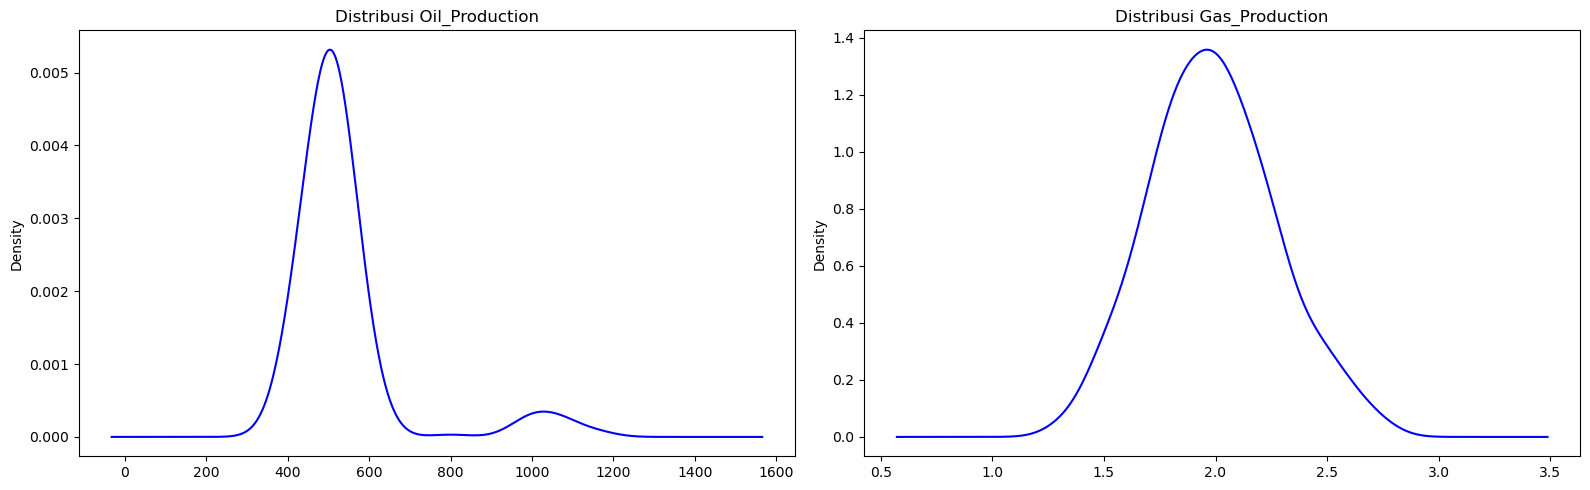

In [92]:
# Plot KDE for Oil_Production and Gas_Production
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

for axes, column in zip(ax, ["Oil_Production", "Gas_Production"]):
    df[column].plot(kind='kde', ax=axes, color='blue', title=f'Distribusi {column}')

plt.tight_layout()
plt.show()

In [94]:
# Dictionary untuk menyimpan metode imputasi tiap kolom

imputation_method = {}

# Imputasi pintar
for column in ["Oil_Production", "Gas_Production"]:
    missing_percentage = df[column].isnull().mean() * 100
    if missing_percentage < 5:
        skew_val = df[column].skew()
        if abs(skew_val) > 0.5:
            # Imputasi pakai median jika skew besar
            df[column] = df[column].fillna(df[column].median())
            imputation_method[column] = "Median (karena skew = {:.2f})".format(skew_val)
        else:
            # Imputasi pakai mean jika distribusi mendekati normal
            df[column] = df[column].fillna(df[column].mean())
            imputation_method[column] = "Mean (karena skew = {:.2f})".format(skew_val)
    else:
        # Kalau missing >5%, pakai ffill + bfill
        df[column] = df[column].ffill().bfill()
        imputation_method[column] = "Forward & Backward Fill (karena missing > 5%)"

# Cetak metode yang digunakan
print("Metode Imputasi per Kolom:")
for col, method in imputation_method.items():
    print(f"- {col}: {method}")

Metode Imputasi per Kolom:
- Oil_Production: Forward & Backward Fill (karena missing > 5%)
- Gas_Production: Forward & Backward Fill (karena missing > 5%)


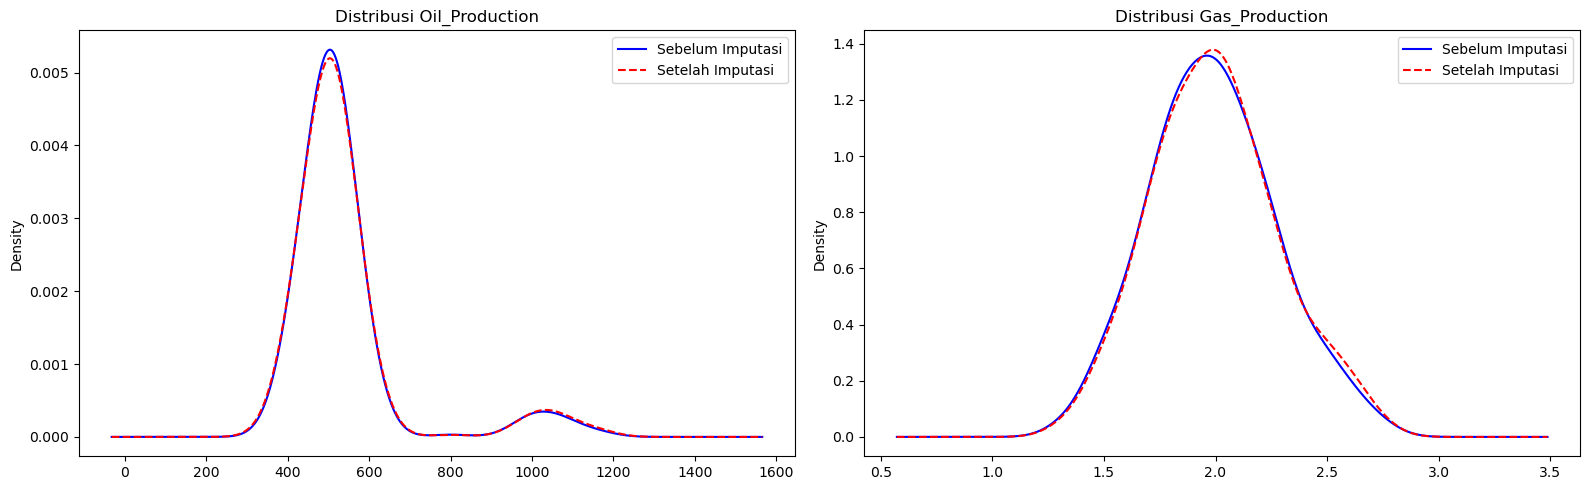

In [96]:
# Bandingkan distribusi sebelum dan sesudah imputasi
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
for axes, col in zip(ax, ["Oil_Production", "Gas_Production"]):
    df_raw[col].dropna().astype(float).plot(kind='kde', ax=axes, label='Sebelum Imputasi', color='blue')
    df[col].plot(kind='kde', ax=axes, label='Setelah Imputasi', color='red', linestyle='--')
    axes.set_title(f'Distribusi {col}')
    axes.legend()
plt.tight_layout()
plt.show()

In [98]:
# Menghapus baris jika lebih dari 30% kolom kosong
# threshold di sini berarti batas minimum jumlah kolom yang harus diisi
# jika jumlah kolom yang kosong lebih dari 30% maka baris tersebut akan dihapus
threshold = 0.3 * len(df.columns)  # 30% dari total kolom
df = df.dropna(thresh=threshold)  # hapus baris jika jumlah kolom kosong lebih dari 30%

In [116]:
target_columns = ['Oil_Production', 'Gas_Production', 'Pressure']

# Hitung Z-score untuk setiap kolom
z_scores = df[target_columns].apply(zscore)  # Hitung Z-score untuk setiap kolom

# Mask untuk mendeteksi outlier (Z-score > 2.5 atau Z-score < -2.5)
outlier_mask = np.abs(z_scores) > 2.5

# Hitung jumlah outlier untuk setiap kolom
outlier_counts = {}
for column in target_columns:
    outlier_counts[column] = outlier_mask[column].sum()  # Hitung jumlah True (outlier)

# Tampilkan hasil
outlier_counts

{'Oil_Production': 21, 'Gas_Production': 2, 'Pressure': 20}

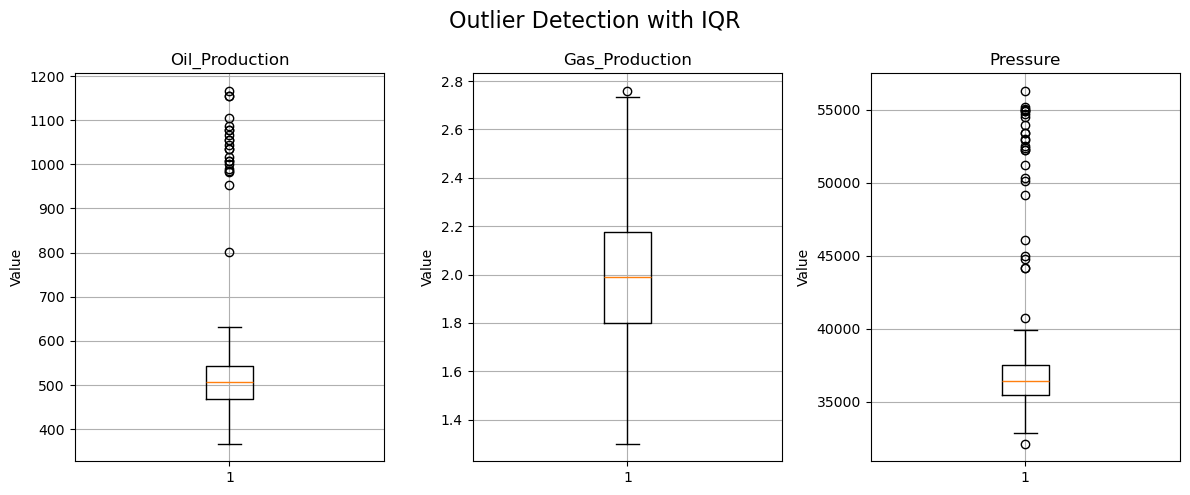

In [118]:
# --- Visualisasi Boxplot untuk Validasi Outlier ---

# Membuat subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  # Subplot untuk setiap kolom

# Loop setiap kolom dan buat boxplot-nya
for i, col in enumerate(target_columns):
    axes[i].boxplot(df[col].dropna())  # Drop NaN sebelum membuat boxplot
    axes[i].set_title(col)  # Set judul masing-masing subplot
    axes[i].set_ylabel('Value')  # Label sumbu y
    axes[i].grid(True)  # Tambahkan grid

# Set layout agar tidak overlapping
plt.suptitle('Outlier Detection with IQR', fontsize=16)  # Judul utama
plt.tight_layout()  # Atur layout agar pas dengan judul
plt.show()

In [104]:
# --- Tandai Special Event jika outlier karena kejadian nyata ---
df["Special_Event"] = outlier_mask.any(axis=1)

# --- Tangani Outlier (yang bukan special event) ---

# Misal: anggap zona = seluruh data sumur
for column in target_columns:
    # Baris yang outlier dan bukan event nyata
    mask = outlier_mask[column] & ~df["Special_Event"]
    
    if column == "Pressure":
        # Untuk Pressure, pakai interpolasi
        df.loc[mask, column] = df[column].interpolate(method='linear')
    else:
        # Untuk produksi minyak & gas, pakai rata-rata zona
        df.loc[mask, column] = df[column].mean()

In [106]:
# Menghapus duplikasi berdasarkan (Date, Well_ID)
df = df.drop_duplicates(subset=["Date", "Well_ID"])

In [108]:
# Standardisasi Format Data
df["Date"] = df["Date"].dt.strftime('%Y-%m-%d')
df["Pressure"] = df["Pressure"] * 14.5038  # Konversi bar ke psi

In [110]:
# # Menyimpan data bersih
cleaned_file_path = "D:\\Haikal Coding\\DATA SCIENTIST\\LIDEA5\\Assets\\cleaned_production_data_history.xlsx"
df.to_excel(cleaned_file_path, index=False)

In [112]:
# Menampilkan hasil akhir cek missing values dan duplikasi
print("Mengecek Missing Values Setelah Pembersihan atau Data Preparasi:")
print(df.isnull().sum(), cleaned_file_path) 
print("Mengecek Data Duplikat Setelah Pembersihan atau Data Preparasi:")
total_duplikat = df.duplicated(subset=["Date", "Well_ID"]).sum()
print(f"Total Data duplikat : {total_duplikat}")

Mengecek Missing Values Setelah Pembersihan atau Data Preparasi:
Date                0
Well_ID             0
Oil_Production      0
Gas_Production      0
Water_Production    0
Choke_Size          0
Pressure            0
Temperature         0
Special_Event       0
dtype: int64 D:\Haikal Coding\DATA SCIENTIST\LIDEA5\Assets\cleaned_production_data_history.xlsx
Mengecek Data Duplikat Setelah Pembersihan atau Data Preparasi:
Total Data duplikat : 0
